# Variational Autoencoder demo with 1D data

Here is [astroNN](https://github.com/henrysky/astroNN), please take a look if you are interested in astronomy or how neural network applied in astronomy
* **Henry W.H. Leung** - *Astronomy Undergraduate, University of Toronto* - [henrysky](https://github.com/henrysky)
* Project advisor: **Jo Bovy** - *Professor, Department of Astronomy and Astrophysics, University of Toronto* - [jobovy](https://github.com/jobovy)
* Contact Henry: henrysky.leung [at] mail.utoronto.ca
* This tutorial is created on 13/Jan/2018 with Keras 2.1.2, Tensorflow 1.4.0, Nvidia CuDNN 6.1 for CUDA 8.0 (Optional), Python 3.6.3 Win10 x64

Import everything we need first

In [1]:
%matplotlib inline  

import numpy as np
import pylab as plt
from scipy.stats import norm

from keras import backend as K
from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras import regularizers

Using TensorFlow backend.


Then define basic constant, function and define our neural network

In [2]:
original_dim = 4000  # Our 1D images dimension, each image has 4000 pixel
intermediate_dim = 256  # Number of neurone our fully connected neural net has

batch_size = 50
epochs = 15
epsilon_std = 1.0

def blackbox_image_generator(pixel, center, sigma):
    return norm.pdf(pixel, center, sigma)

def nll(y_true, y_pred):
    """
    Negative log likelihood
    
    Mean Squared Error is a terrible choice as a reconstruction loss
    Its an issue as stated in arXiv:1511.05440
    Why? See till the end of this notebook :)
    """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


class KLDivergenceLayer(Layer):

    """ 
    Identity transform layer that adds KL divergence to the final model loss.
    KL divergence used to force the latent space match the prior (in this case its unit gaussian)
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super().__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

def model_decoder(latent_dim):
    """ 
    Decoder Model
    """
    model = Sequential()
    model.add(Dense(intermediate_dim, input_dim=latent_dim, activation='relu'))
    model.add(Dense(original_dim, activation='sigmoid'))
    return model

def model_vae(latent_dim):
    """ 
    Main Model + Encoder
    """
    x = Input(shape=(original_dim,))
    h = Dense(intermediate_dim, activation='relu')(x)

    z_mu = Dense(latent_dim, kernel_regularizer=regularizers.l2(1e-4))(h)
    z_log_var = Dense(latent_dim)(h)

    z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
    z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

    eps = Input(tensor=K.random_normal(stddev=epsilon_std, shape=(K.shape(x)[0], latent_dim)))
    
    z_eps = Multiply()([z_sigma, eps])
    z = Add()([z_mu, z_eps])
    
    decoder = model_decoder(latent_dim)
    x_pred = decoder(z)

    vae = Model(inputs=[x, eps], outputs=x_pred)
    vae.compile(optimizer='rmsprop', loss=nll)
    
    encoder = Model(x, z_mu)
    
    return vae, encoder

Now we will generate some true latent variable so we can pass them to a blackbox image generator to generate some 1D images.

The blackbox image generator (which is deterministic) will take two numbers and generate images in a predictable way. This is important because if the generator generate image in a random way, then there is nothing neural network can learn.

But for simplicity, we will fix the first latent variable of the blackbox image generator a constant and only use the second one to generate images.

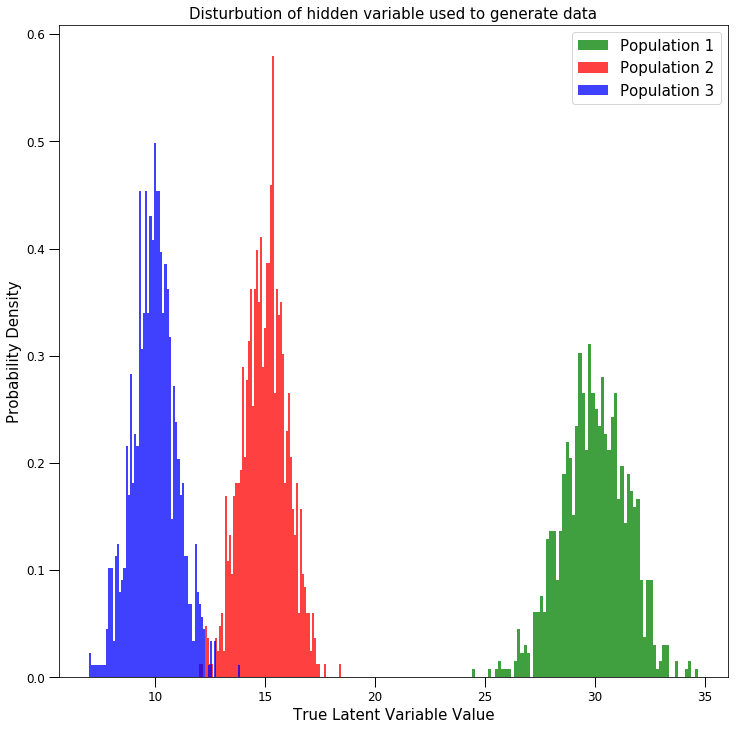

In [3]:
s_1 = np.random.normal(30, 1.5, 900)
s_2 = np.random.normal(15, 1, 900)
s_3 = np.random.normal(10, 1, 900)

s = np.concatenate([s_1, s_2, s_3])

plt.figure(figsize=(12, 12))
plt.hist(s[:900], 70, normed=1, facecolor='green', alpha=0.75, label='Population 1')
plt.hist(s[900:1800], 70, normed=1, facecolor='red', alpha=0.75, label='Population 2')
plt.hist(s[1800:], 70, normed=1, facecolor='blue', alpha=0.75, label='Population 3')
plt.title('Disturbution of hidden variable used to generate data', fontsize=15)
plt.xlabel('True Latent Variable Value', fontsize=15)
plt.ylabel('Probability Density', fontsize=15)
plt.tick_params(labelsize=12, width=1, length=10)
plt.legend(loc='best', fontsize=15)
plt.show()

Now we will pass the true latent variable to the blackbox image generator to generate some images. Below are the example
images from the three populations. They may seems to have no difference but neural network will pick up some subtle features
usually.

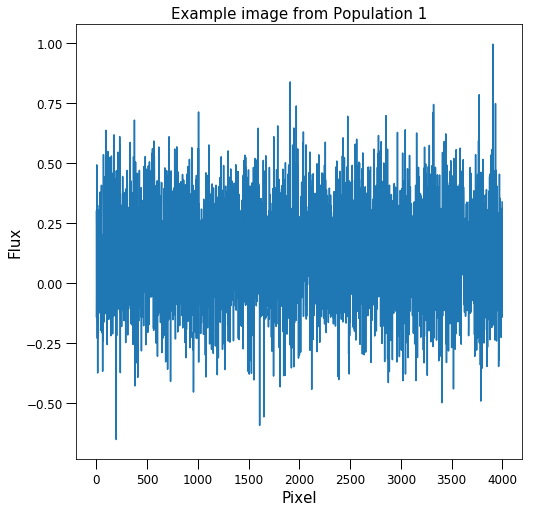

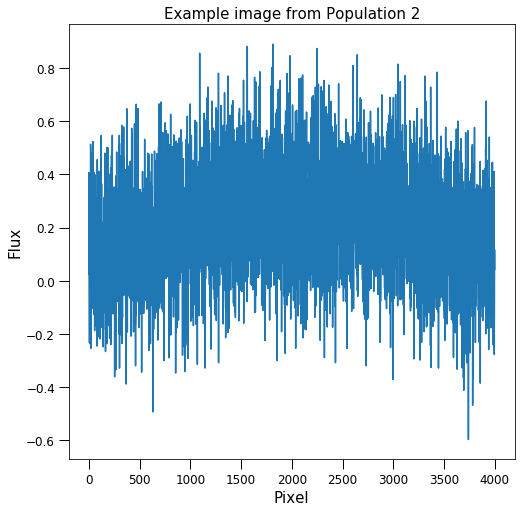

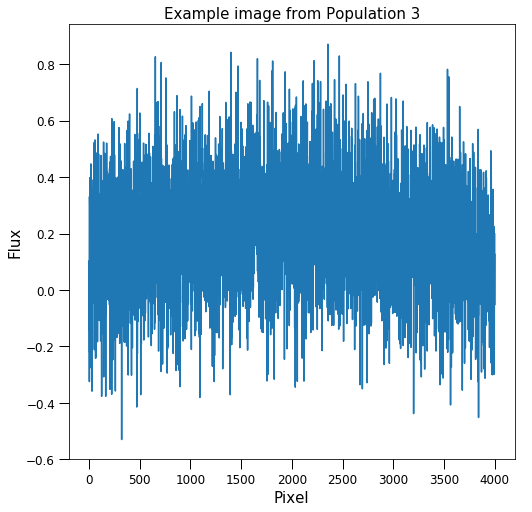

In [4]:
# We have some images, each has 4000 pixels
x_train = np.zeros((len(s), original_dim))
for counter, S in enumerate(s):
    xs = np.linspace(0, 40, original_dim)
    x_train[counter] = blackbox_image_generator(xs, 20, S)

# Prevent nan causes error
x_train[np.isnan(x_train.astype(float))] = 0

x_train *= 10

# Add some noise to our images
x_train += np.random.normal(0, 0.2, x_train.shape)

plt.figure(figsize=(8, 8))
plt.title('Example image from Population 1', fontsize=15)
plt.plot(x_train[500])
plt.xlabel('Pixel', fontsize=15)
plt.ylabel('Flux', fontsize=15)
plt.tick_params(labelsize=12, width=1, length=10)
plt.legend(loc='best', fontsize=15)
plt.show()

plt.figure(figsize=(8, 8))
plt.title('Example image from Population 2', fontsize=15)
plt.plot(x_train[1000])
plt.xlabel('Pixel', fontsize=15)
plt.ylabel('Flux', fontsize=15)
plt.tick_params(labelsize=12, width=1, length=10)
plt.legend(loc='best', fontsize=15)
plt.show()

plt.figure(figsize=(8, 8))
plt.title('Example image from Population 3', fontsize=15)
plt.plot(x_train[1600])
plt.xlabel('Pixel', fontsize=15)
plt.ylabel('Flux', fontsize=15)
plt.tick_params(labelsize=12, width=1, length=10)
plt.legend(loc='best', fontsize=15)
plt.show()

Now we will pass the images to the neural network and train with them.

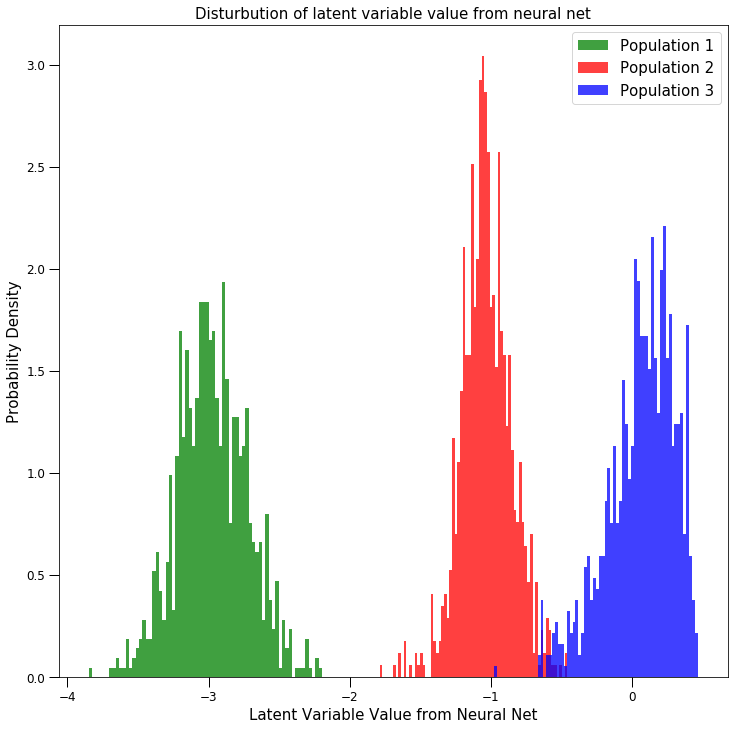

In [5]:
latent_dim = 1  # Dimension of our latent space
vae, encoder = model_vae(latent_dim)

vae.fit(x_train, x_train, shuffle=True, epochs=epochs, batch_size=batch_size, verbose=0)

z_test = encoder.predict(x_train, batch_size=batch_size)

plt.figure(figsize=(12, 12))
plt.hist(z_test[:900], 70, normed=1, facecolor='green', alpha=0.75, label='Population 1')
plt.hist(z_test[900:1800], 70, normed=1, facecolor='red', alpha=0.75, label='Population 2')
plt.hist(z_test[1800:], 70, normed=1, facecolor='blue', alpha=0.75, label='Population 3')
plt.title('Disturbution of latent variable value from neural net', fontsize=15)
plt.xlabel('Latent Variable Value from Neural Net', fontsize=15)
plt.ylabel('Probability Density', fontsize=15)
plt.tick_params(labelsize=12, width=1, length=10)
plt.legend(loc='best', fontsize=15)
plt.show()

Yay!! Seems like the neural network recovered the three population successfully. Althought the recovered latent variable is not exactly the same as the original ones we generated (I mean at least the scale isn't the same), usually you won't expect the neural network can learn the real phyiscs. In this case, the latent variable is just some transformations from the original ones.

You should still remember that we have fixed the first latent variable of the blackbox image generator. What happes if we also generate 3 populations for the first latent variable, and the first latent variable will have no correlation with the second latent variable (Meaning if you know the first latent value of an object, you have no information gain on the second latent value of that object because the first and second have nothing to do with each other)

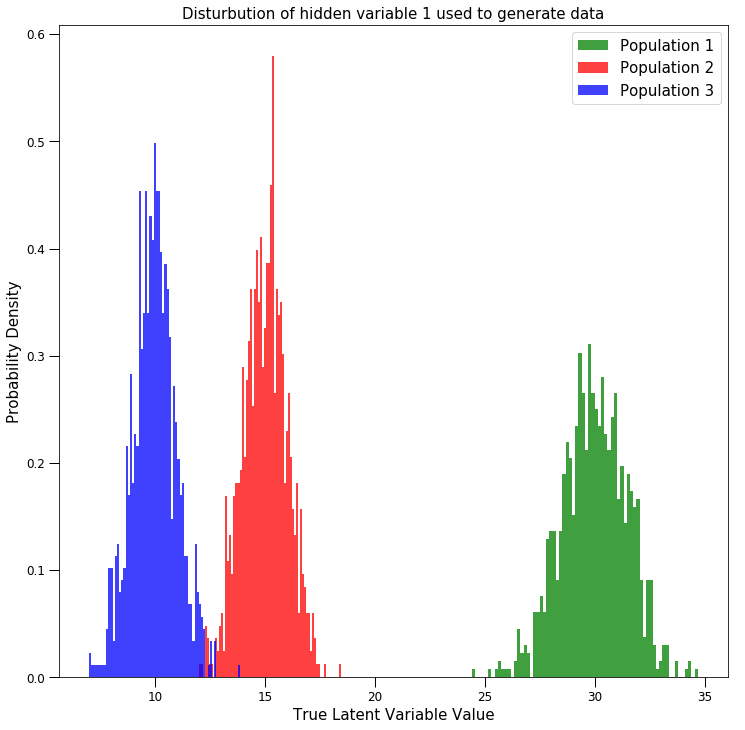

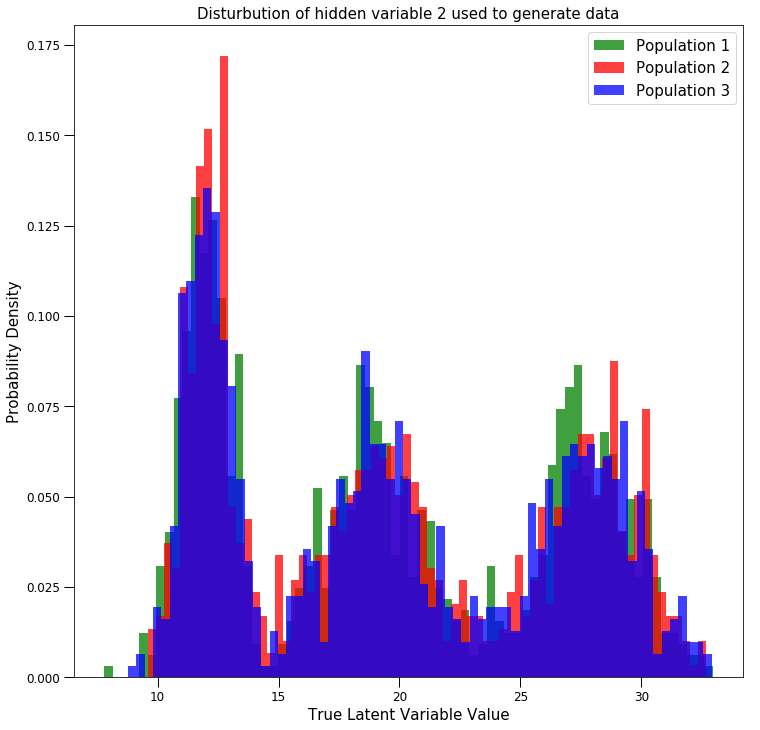

In [6]:
m_1A = np.random.normal(28, 2, 300)
m_1B = np.random.normal(19, 2, 300)
m_1C = np.random.normal(12, 1, 300)

m_2A = np.random.normal(28, 2, 300)
m_2B = np.random.normal(19, 2, 300)
m_2C = np.random.normal(12, 1, 300)

m_3A = np.random.normal(28, 2, 300)
m_3B = np.random.normal(19, 2, 300)
m_3C = np.random.normal(12, 1, 300)

m = np.concatenate([m_1A, m_1B, m_1C, m_2A, m_2B, m_2C, m_3A, m_3B, m_3C])

x_train = np.zeros((len(s), original_dim))
for counter in range(len(s)):
    xs = np.linspace(0, 40, original_dim)
    x_train[counter] = blackbox_image_generator(xs, m[counter], s[counter])
    
# Prevent nan causes error
x_train[np.isnan(x_train.astype(float))] = 0

x_train *= 10

# Add some noise to our images
x_train += np.random.normal(0, 0.1, x_train.shape)    


plt.figure(figsize=(12, 12))
plt.hist(s[:900], 70, normed=1, facecolor='green', alpha=0.75, label='Population 1')
plt.hist(s[900:1800], 70, normed=1, facecolor='red', alpha=0.75, label='Population 2')
plt.hist(s[1800:], 70, normed=1, facecolor='blue', alpha=0.75, label='Population 3')
plt.title('Disturbution of hidden variable 1 used to generate data', fontsize=15)
plt.xlabel('True Latent Variable Value', fontsize=15)
plt.ylabel('Probability Density', fontsize=15)
plt.tick_params(labelsize=12, width=1, length=10)
plt.legend(loc='best', fontsize=15)
plt.show()

plt.figure(figsize=(12, 12))
plt.hist(m[:900], 70, normed=1, facecolor='green', alpha=0.75, label='Population 1')
plt.hist(m[900:1800], 70, normed=1, facecolor='red', alpha=0.75, label='Population 2')
plt.hist(m[1800:], 70, normed=1, facecolor='blue', alpha=0.75, label='Population 3')
plt.title('Disturbution of hidden variable 2 used to generate data', fontsize=15)
plt.xlabel('True Latent Variable Value', fontsize=15)
plt.ylabel('Probability Density', fontsize=15)
plt.tick_params(labelsize=12, width=1, length=10)
plt.legend(loc='best', fontsize=15)
plt.show()

Since we have two independent variables to generate our images, what happened if you still try to force the neural network to explain the images with just one variable?

Before we run the training, we should think about what we expect first. Lets denate the first latent variable population as 1, 2 and 3 , while the second latent variable population as A, B and C. If we know an object is in population 2, it has equal chance that its in population A, B and C. With this logic, we should have 9 unique population in total (1A, 1B, 1C, 2A, 2B, 2C, 3A, 3B, 3C). If the neural network want to explain the images with 1 latent variable, it should has 9 peaks in the plot.

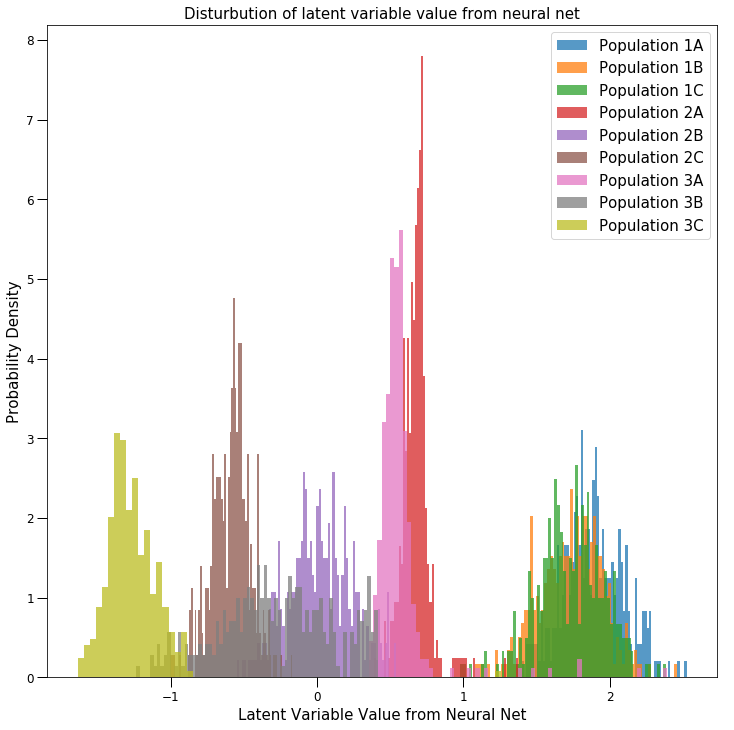

In [7]:
latent_dim = 1  # Dimension of our latent space
vae, encoder = model_vae(latent_dim)
epochs = 15

vae.fit(x_train, x_train, shuffle=True, epochs=epochs, batch_size=batch_size, verbose=0)

z_test = encoder.predict(x_train, batch_size=batch_size)

plt.figure(figsize=(12, 12))
# plt.hist(z_test[:900], 70, normed=1, facecolor='green', alpha=0.75, label='Population 1')
# plt.hist(z_test[900:1800], 70, normed=1, facecolor='red', alpha=0.75, label='Population 2')
# plt.hist(z_test[1800:], 70, normed=1, facecolor='blue', alpha=0.75, label='Population 3')

plt.hist(z_test[:300], 70, normed=1, alpha=0.75, label='Population 1A')
plt.hist(z_test[300:600], 70, normed=1, alpha=0.75, label='Population 1B')
plt.hist(z_test[600:900], 70, normed=1, alpha=0.75, label='Population 1C')

plt.hist(z_test[900:1200], 70, normed=1, alpha=0.75, label='Population 2A')
plt.hist(z_test[1200:1500], 70, normed=1, alpha=0.75, label='Population 2B')
plt.hist(z_test[1500:1800], 70, normed=1, alpha=0.75, label='Population 2C')

plt.hist(z_test[1800:2100], 70, normed=1, alpha=0.75, label='Population 3A')
plt.hist(z_test[2100:2400], 70, normed=1, alpha=0.75, label='Population 3B')
plt.hist(z_test[2400:2700], 70, normed=1, alpha=0.75, label='Population 3C')

plt.title('Disturbution of latent variable value from neural net', fontsize=15)
plt.xlabel('Latent Variable Value from Neural Net', fontsize=15)
plt.ylabel('Probability Density', fontsize=15)
plt.tick_params(labelsize=12, width=1, length=10)
plt.legend(loc='best', fontsize=15)
plt.show()

By visual inspection, seems like the neural network only recovered 6 population :(

What will happen if we increase the latent space of the nerual network to 2?

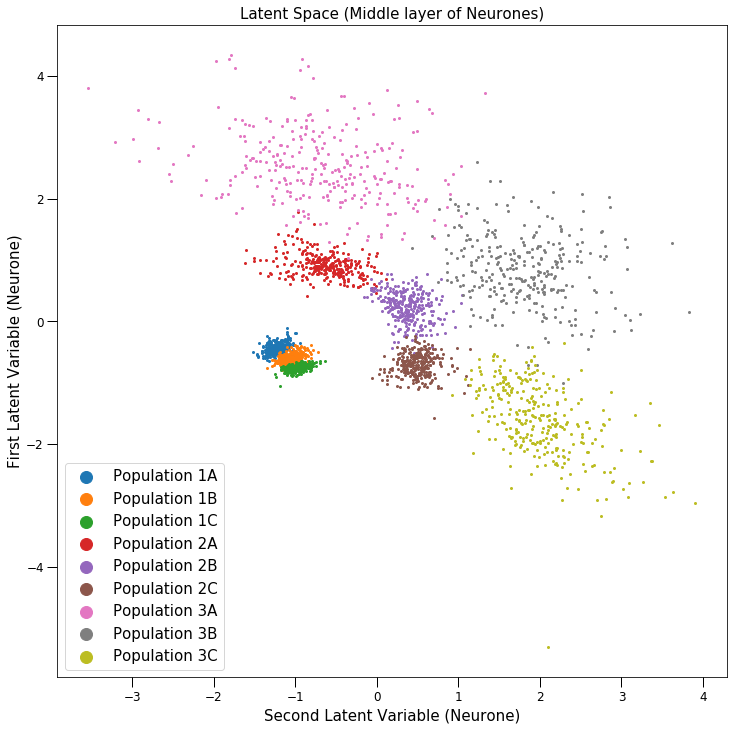

In [8]:
latent_dim = 2  # Dimension of our latent space
epochs = 40

vae, encoder = model_vae(latent_dim)

vae.fit(x_train, x_train, shuffle=True, epochs=epochs, batch_size=batch_size, verbose=0)

z_test = encoder.predict(x_train, batch_size=batch_size)

plt.figure(figsize=(12, 12))
plt.scatter(z_test[:300, 0], z_test[:300, 1], s=4, label='Population 1A')
plt.scatter(z_test[300:600, 0], z_test[300:600, 1], s=4, label='Population 1B')
plt.scatter(z_test[600:900, 0], z_test[600:900, 1], s=4, label='Population 1C')

plt.scatter(z_test[900:1200, 0], z_test[900:1200, 1], s=4, label='Population 2A')
plt.scatter(z_test[1200:1500, 0], z_test[1200:1500, 1], s=4, label='Population 2B')
plt.scatter(z_test[1500:1800, 0], z_test[1500:1800, 1], s=4, label='Population 2C')

plt.scatter(z_test[1800:2100, 0], z_test[1800:2100, 1], s=4, label='Population 3A')
plt.scatter(z_test[2100:2400, 0], z_test[2100:2400, 1], s=4, label='Population 3B')
plt.scatter(z_test[2400:2700, 0], z_test[2400:2700, 1], s=4, label='Population 3C')

plt.title('Latent Space (Middle layer of Neurones)', fontsize=15)
plt.xlabel('Second Latent Variable (Neurone)', fontsize=15)
plt.ylabel('First Latent Variable (Neurone)', fontsize=15)
plt.tick_params(labelsize=12, width=1, length=10)
plt.legend(loc='best', fontsize=15, markerscale=6)
plt.show()

### Why using Mean-Square-Error as reconstruction loss is a bad idea?

Mean-Square-Error: $\frac{1}{T} \sum  (\hat x-x)^2$

Gaussian disturbution: $P(x|\mu,\sigma)=\frac{1}{C} exp(\frac{(\mu-x)^2}{2\sigma^2})$

Lets set $\mu$ as our datapoint and $\sigma$ as 1 for simplicity

= $p(x|\hat x) \propto exp(\frac{(\mu-x)^2}{2})$

Taking log, $log(p(x|\hat x)) \propto \sum  (\hat x-x)^2$

Which means use mean square error (as an objective function which minimizing the MSE/L2 loss) is equivalent maximizing the log-likelihood of a Gaussian. We are assuming our data is somehow gaussian which may or may not be true.

Thats why the reconstructed images are blurry if we use mean square error loss, our real world data highly probably come from multimodal distribution, which we fit a gaussian with it in optimization process with mean square error objective.

In real world, even though our data are multimodal distribution, $P(x|z)$ could be unimodel which can be fitted with a gaussian if $z$ is informative enough, and I have shown in this demo, x can be quite informative.

For reference: arXiv:1511.05440, arXiv:1702.08658